In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.utils import to_categorical
from keras.models import Model
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import scipy

1999 0.61 0.46


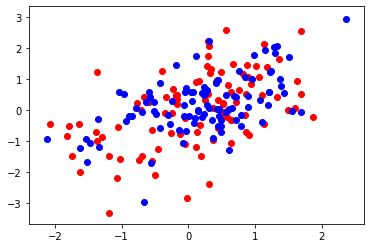

3999 0.62 0.43


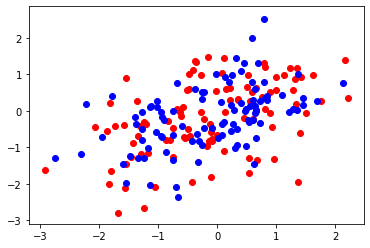

5999 0.51 0.31


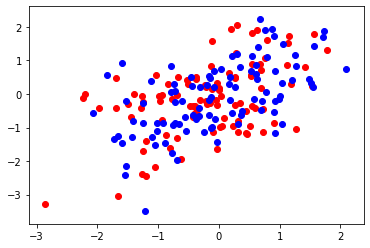

7999 0.01 0.97


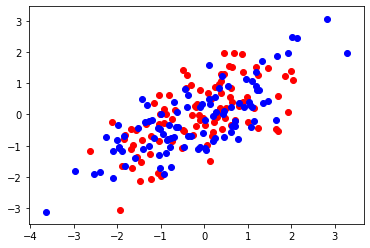

9999 0.36 0.86


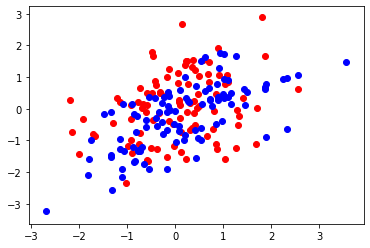

In [32]:
#Quick vanilla GAN from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))    
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	Z1 = np.random.normal(0,1,n)
	Z2 = np.random.normal(0,1,n)
	rho = 0.5
    
	X1 = Z1
	X2 = rho*Z1 + np.sqrt(1.-rho**2)*Z2
    
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)    
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [33]:
xvals,yvals = generate_fake_samples(generator, latent_dim, 100000)

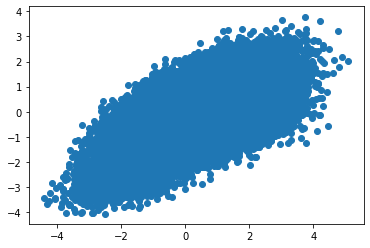

In [34]:
plt.scatter(xvals[:, 0],xvals[:, 1])

In [35]:
print(np.mean(xvals[:, 0]))
print(np.std(xvals[:, 0]))

print(np.mean(xvals[:, 1]))
print(np.std(xvals[:, 1]))

print(scipy.stats.pearsonr(xvals[:, 0],xvals[:, 1])[0])

0.07894659
1.1203839
-0.19999984
1.0051223
0.6486153449079094


In [6]:
#Now, let's try to DCTR this up!

In [36]:
xvalsR,yvalsR = generate_real_samples(100000)

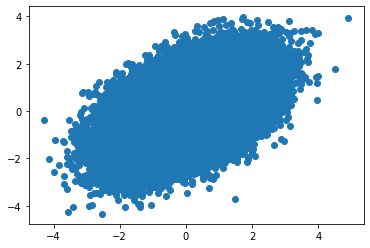

In [37]:
plt.scatter(xvalsR[:, 0],xvalsR[:, 1])

In [38]:
print(np.mean(xvalsR[:, 0]))
print(np.std(xvalsR[:, 0]))

print(np.mean(xvalsR[:, 1]))
print(np.std(xvalsR[:, 1]))

print(scipy.stats.pearsonr(xvalsR[:, 0],xvalsR[:, 1])[0])

0.000998230486103162
0.9980008200852595
0.002413602967930827
0.9999069885147919
0.49801185962585603


In [39]:
X = np.concatenate([xvalsR,xvals])
Y = np.concatenate([yvalsR,yvals])
Y = to_categorical(Y)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [41]:
inputs = Input((2,))
hidden_layer_1 = Dense(20, activation='relu')(inputs)
hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 42        
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [42]:
earlystopping = EarlyStopping(patience = 10)
model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size = 1000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 160000 samples, validate on 40000 samples
Epoch 1/100
160000/160000 [==============================] - 1s 8us/step - loss: 0.6740 - val_loss: 0.6697
Epoch 2/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6693 - val_loss: 0.6685
Epoch 3/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6680 - val_loss: 0.6669
Epoch 4/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6670 - val_loss: 0.6660
Epoch 5/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6666 - val_loss: 0.6656
Epoch 6/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6659 - val_loss: 0.6654
Epoch 7/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6657 - val_loss: 0.6659
Epoch 8/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6653 - val_loss: 0.6649
Epoch 9/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6650 - val

160000/160000 [==============================] - 1s 6us/step - loss: 0.6581 - val_loss: 0.6599
Epoch 77/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6582 - val_loss: 0.6595
Epoch 78/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6601
Epoch 79/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6593
Epoch 80/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6597
Epoch 81/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6603
Epoch 82/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6599
Epoch 83/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6580 - val_loss: 0.6592


In [43]:
preds = model.predict(X_test)
weights = preds[:,1]/preds[:,0]

(array([  91., 1238.,  976., 1615., 2227., 3555., 4404., 2584., 1141.,
         680.,  412.,  286.,  153.,   83.,   56.,   54.,   68.,   35.,
          34.]),
 array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
        0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
        1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
        2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ]),
 <a list of 19 Patch objects>)

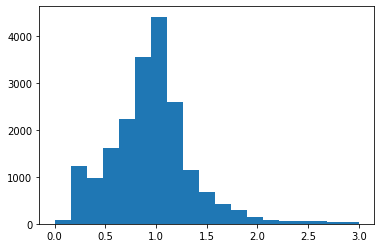

In [44]:
plt.hist(weights[Y_test[:,0]==1],bins=np.linspace(0,3,20))

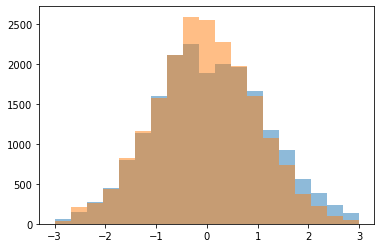

In [45]:
_,_,_=plt.hist(X_test[Y_test[:,0]==1][:, 0],alpha=0.5,bins=np.linspace(-3,3,20))
_,_,_=plt.hist(X_test[Y_test[:,0]==1][:, 0],weights=weights[Y_test[:,0]==1],alpha=0.5,bins=np.linspace(-3,3,20))

In [53]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def std(x, w):
    """Weighted Covariance"""
    return cov(x,x,w)**0.5

In [56]:
print("X1 mean")
print("DCTRGAN:",np.average(X_test[Y_test[:,0]==1][:,0],weights=weights[Y_test[:,0]==1]))
print("GAN:",np.average(X_test[Y_test[:,0]==1][:,0]))

print("X2 mean")
print("DCTRGAN:",np.average(X_test[Y_test[:,0]==1][:,1],weights=weights[Y_test[:,0]==1]))
print("GAN:",np.average(X_test[Y_test[:,0]==1][:,1]))

print("\n")

print("X1 standard deviation")
print("DCTRGAN:",std(X_test[Y_test[:,0]==1][:,0],weights[Y_test[:,0]==1]))
print("GAN:",std(X_test[Y_test[:,0]==1][:,0],np.ones(len(X_test[Y_test[:,0]==1]))))

print("X2 standard deviation")
print("DCTRGAN:",std(X_test[Y_test[:,0]==1][:,1],weights[Y_test[:,0]==1]))
print("GAN:",std(X_test[Y_test[:,0]==1][:,1],np.ones(len(X_test[Y_test[:,0]==1]))))

print("\n")

print("X1,X2 correlation")
print("DCTRGAN:",corr(X_test[Y_test[:,0]==1][:,0],X_test[Y_test[:,0]==1][:,1],weights[Y_test[:,0]==1]))
print("GAN:",corr(X_test[Y_test[:,0]==1][:,0],X_test[Y_test[:,0]==1][:,1],np.ones(len(X_test[Y_test[:,0]==1]))))

X1 mean
DCTRGAN: -0.038893118623462286
GAN: 0.06714635978844259
X2 mean
DCTRGAN: -0.016131852984098367
GAN: -0.21643264626812306


X1 standard deviation
DCTRGAN: 1.0123614673085537
GAN: 1.1274273990978627
X2 standard deviation
DCTRGAN: 1.0117445336448037
GAN: 1.0154279286594114


X1,X2 correlation
DCTRGAN: 0.496575742119486
GAN: 0.657081736842469
